In [ ]:
%matplotlib inline
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor
import seaborn as sns

np.random.seed(42)

# Data Generation

Original Data Std Dev: 1.0034122061299875
Noisy Data Std Dev: 1.7987179956760222


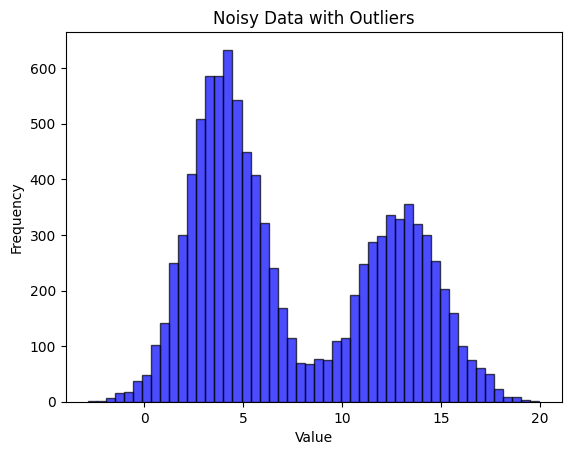

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_noisy_data(n_samples=10000, mean=4, std=1, noise_level = 0.5, outlier_frac=0.1):
    np.random.seed(42)
    data = np.random.normal(mean, std, size=n_samples)
    print("Original Data Std Dev:", np.std(data))

    # Add Gaussian noise
    noise = np.random.normal(0, noise_level, size=n_samples)
    data_noisy = data + noise
    print("Noisy Data Std Dev:", np.std(data_noisy))

    # Introduce outliers
    num_outliers = int(outlier_frac * n_samples)
    outlier_indices = np.random.choice(n_samples, num_outliers, replace=False)
    data_noisy[outlier_indices] += np.random.normal(loc = 9, scale = 1, size = num_outliers)  # Extreme shift with np.random.uniform(15, 20, size=num_outliers)

    return data_noisy

# Generate and plot
noise_level = 1.5
outlier_frac = 0.4
data = generate_noisy_data(noise_level=noise_level, outlier_frac= outlier_frac)
plt.hist(data, bins=50, alpha=0.7, color='b', edgecolor='black')
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Noisy Data with Outliers")
plt.show()


In [ ]:
type(data)

numpy.ndarray

# Student T

In [ ]:
with pm.Model() as studentT_model:
    mu = pm.Normal("mu_T", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma_T", sigma=5)
    nu = pm.Gamma("nu_T", alpha=2, beta=0.1)

    y_obs = pm.StudentT("y_obs", mu=mu, sigma=sigma, nu=nu, observed=data)

In [ ]:
with studentT_model:
    mean_field = pm.fit(obj_optimizer=pm.adagrad_window(learning_rate=1e-2))

Output()

In [ ]:
with studentT_model:
    trace = pm.sample()

Output()

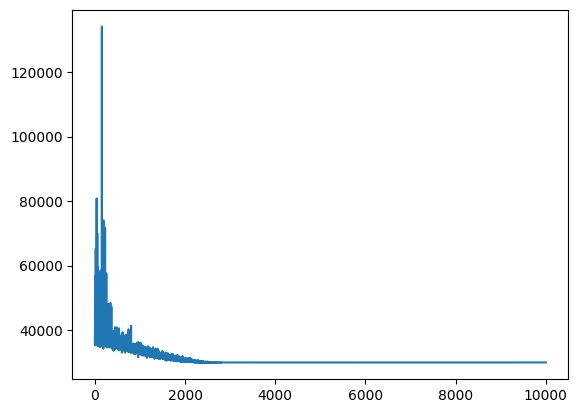

In [ ]:
plt.plot(mean_field.hist)

array([[<Axes: title={'center': 'mu_T'}>,
        <Axes: title={'center': 'mu_T'}>],
       [<Axes: title={'center': 'nu_T'}>,
        <Axes: title={'center': 'nu_T'}>],
       [<Axes: title={'center': 'sigma_T'}>,
        <Axes: title={'center': 'sigma_T'}>]], dtype=object)

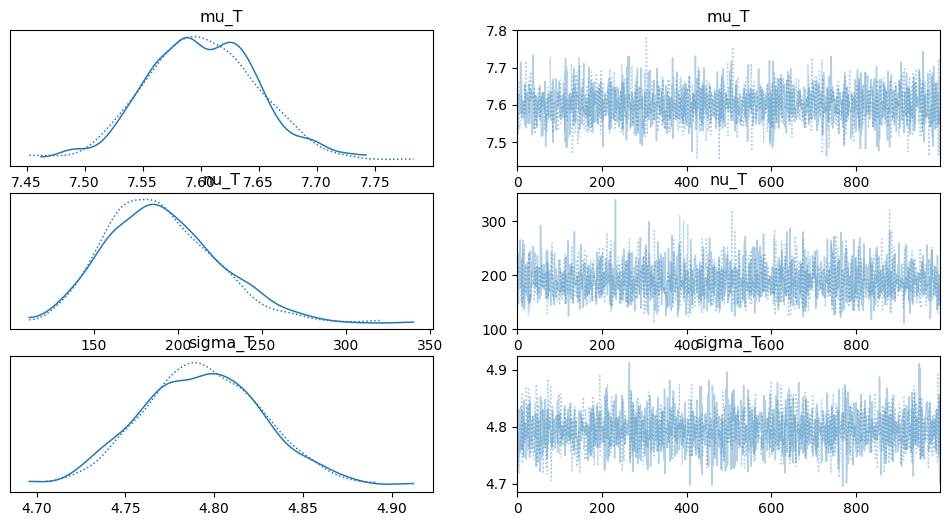

In [ ]:
az.plot_trace(trace)

array([<Axes: title={'center': 'mu_T'}>, <Axes: title={'center': 'nu_T'}>,
       <Axes: title={'center': 'sigma_T'}>], dtype=object)

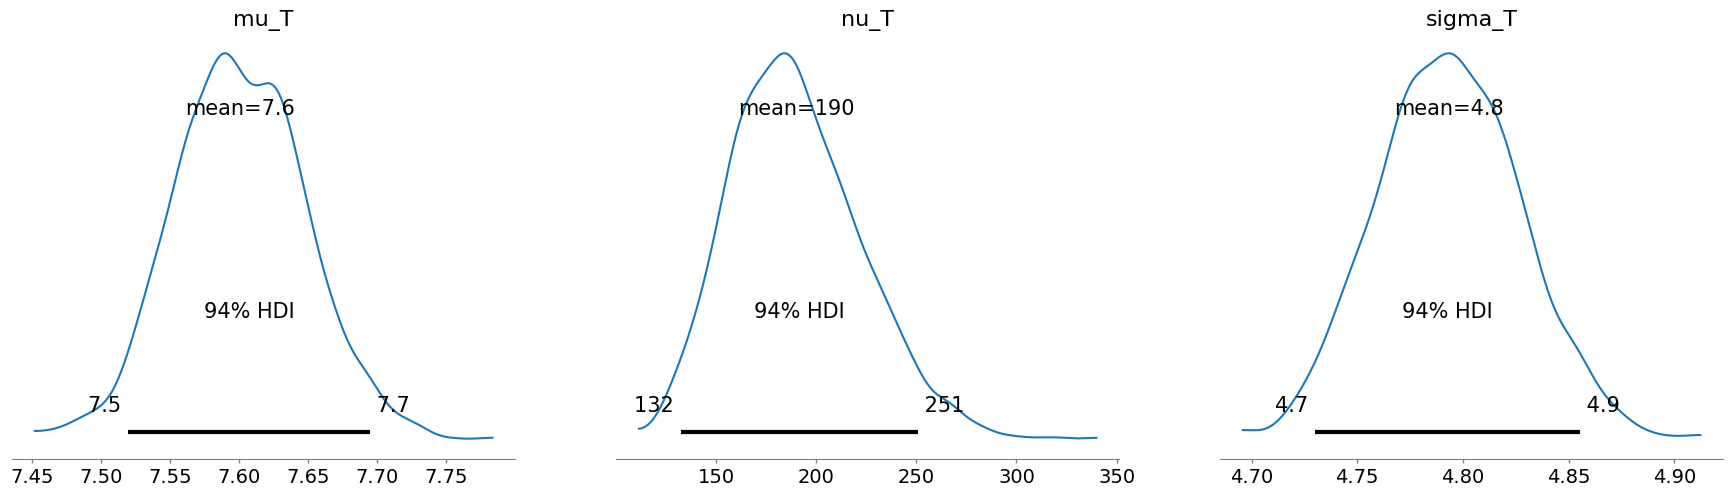

In [ ]:
az.plot_posterior(trace)

# Normal

In [ ]:
with pm.Model() as normal_model:
    mu = pm.Normal("mu_norm", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma_norm", sigma=5)
    y_norm = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=data)

In [ ]:
with normal_model:
    norm_mean_field = pm.fit(obj_optimizer=pm.adagrad_window(learning_rate=1e-2))

Output()

In [ ]:
with normal_model:
    trace_norm = pm.sample()

Output()

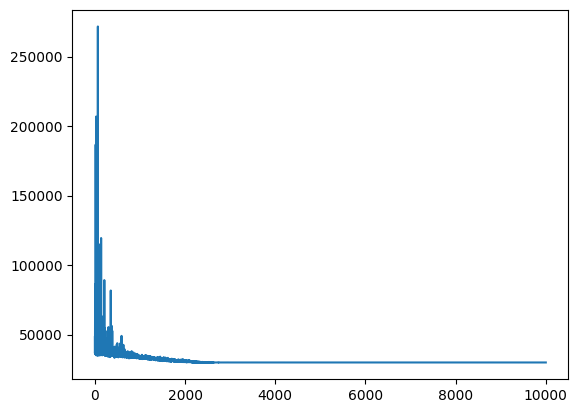

In [ ]:
plt.plot(norm_mean_field.hist)

array([[<Axes: title={'center': 'mu_norm'}>,
        <Axes: title={'center': 'mu_norm'}>],
       [<Axes: title={'center': 'sigma_norm'}>,
        <Axes: title={'center': 'sigma_norm'}>]], dtype=object)

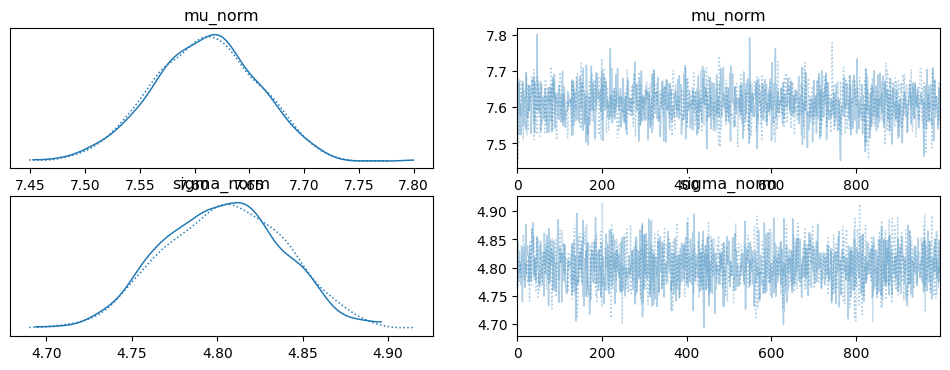

In [ ]:
az.plot_trace(trace_norm)

array([<Axes: title={'center': 'mu_norm'}>,
       <Axes: title={'center': 'sigma_norm'}>], dtype=object)

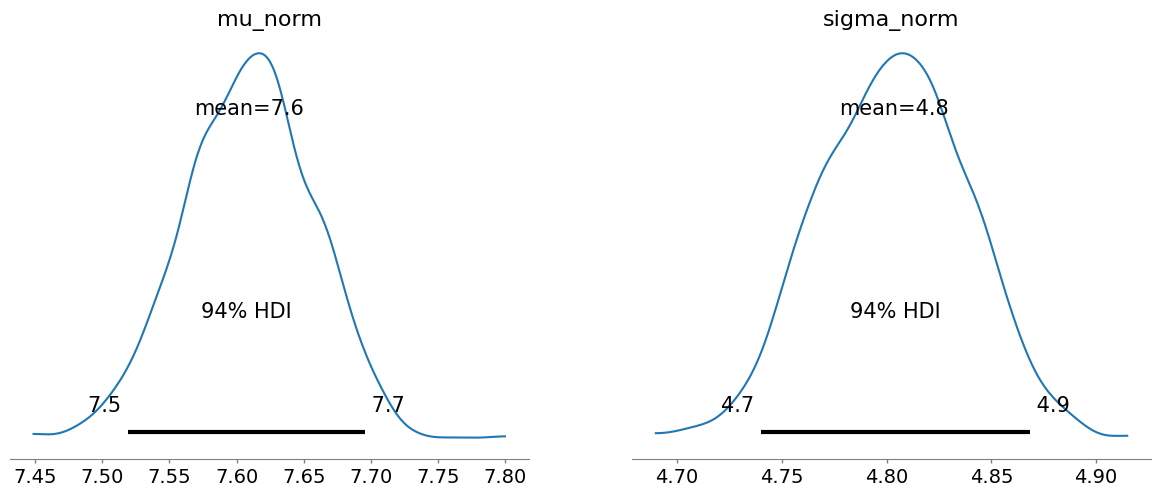

In [ ]:
az.plot_posterior(trace_norm)

# Skew Normal

In [ ]:
with pm.Model() as skew_normal_model:
    mu = pm.Normal("mu_skewed", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma_skewed", sigma=5)
    alpha = pm.Normal("alpha", mu=0, sigma=5)
    y_obs = pm.SkewNormal("y_obs", mu=mu, sigma=sigma, alpha=alpha, observed=data)

In [ ]:
with skew_normal_model:
    skewnorm_mean_field = pm.fit(obj_optimizer=pm.adagrad_window(learning_rate=1e-2))

Output()

In [ ]:
with skew_normal_model:
    trace_skewnorm = pm.sample()

Output()

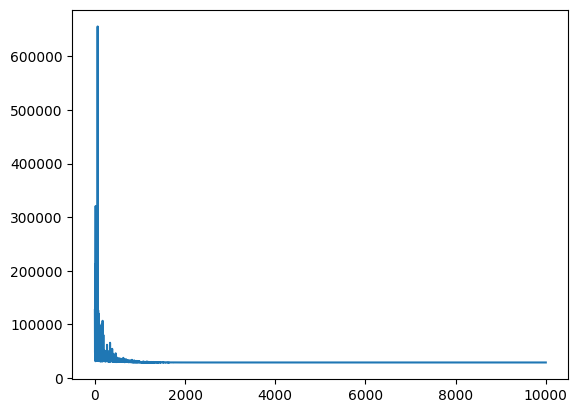

In [ ]:
plt.plot(skewnorm_mean_field.hist)

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'mu_skewed'}>,
        <Axes: title={'center': 'mu_skewed'}>],
       [<Axes: title={'center': 'sigma_skewed'}>,
        <Axes: title={'center': 'sigma_skewed'}>]], dtype=object)

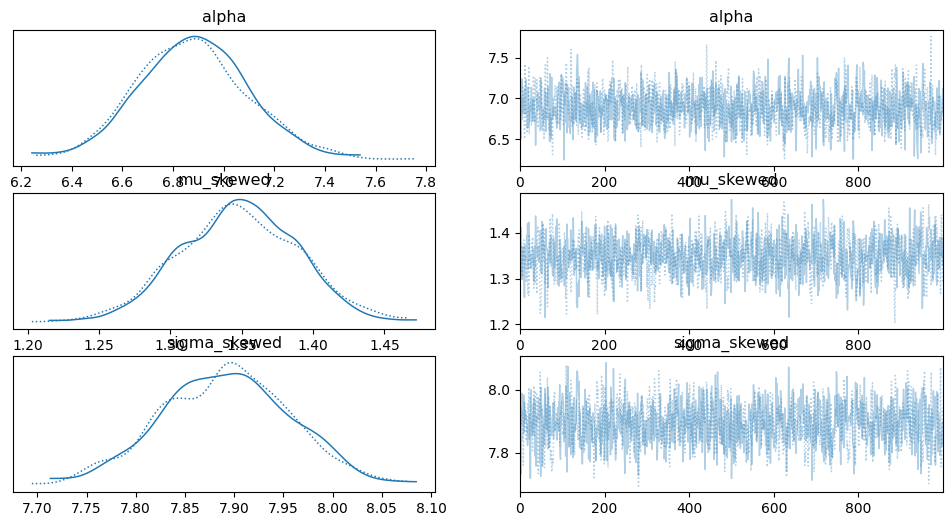

In [ ]:
az.plot_trace(trace_skewnorm)

array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'mu_skewed'}>,
       <Axes: title={'center': 'sigma_skewed'}>], dtype=object)

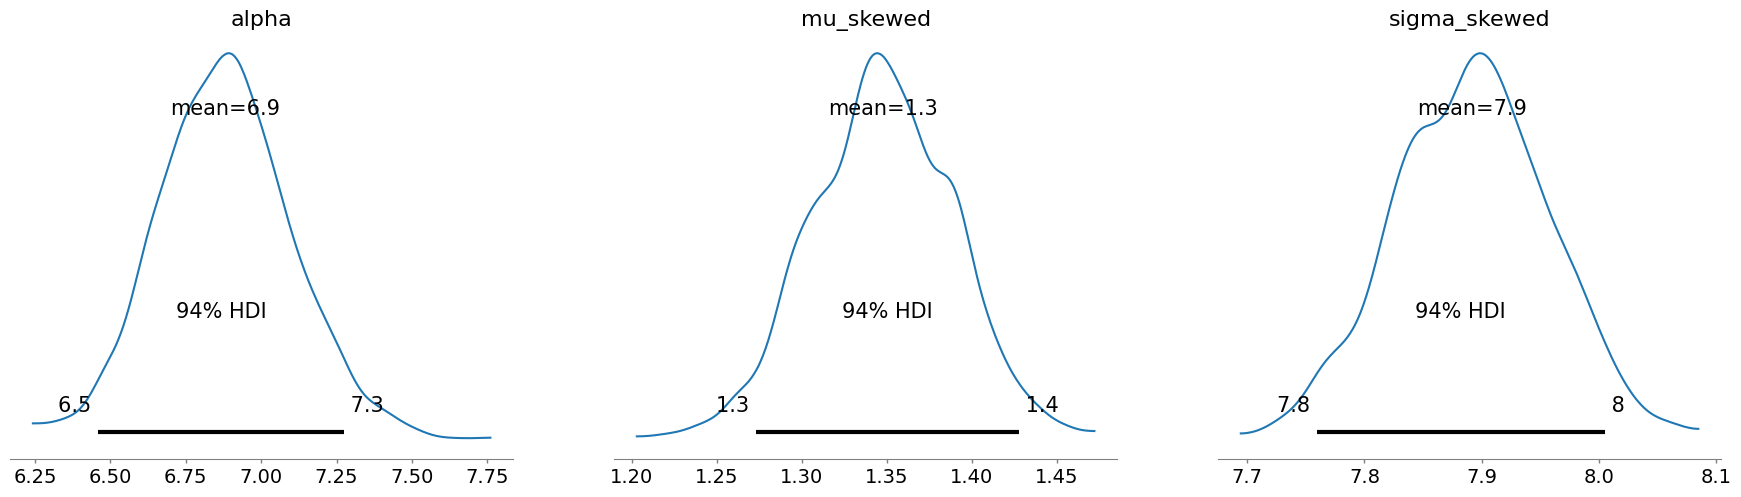

In [ ]:
az.plot_posterior(trace_skewnorm)

# Obtaining Weights by Stacking

In [ ]:
rng = np.random.seed(2741)

In [ ]:
with studentT_model:
    pm.compute_log_likelihood(trace)
with normal_model:
    pm.compute_log_likelihood(trace_norm)
with skew_normal_model:
    pm.compute_log_likelihood(trace_skewnorm)

Output()

Output()

Output()

In [ ]:
df_comp = az.compare({"Student T": trace, "Normal": trace_norm, "Skew Normal": trace_skewnorm}, method = 'stacking')
df_comp

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Skew Normal,0,-28971.988629,2.767207,0.000000,9.862744e-01,61.842499,0.000000,False,log
Normal,1,-29883.017974,1.403619,911.029346,1.372556e-02,43.337010,37.137235,False,log
Student T,2,-29899.858039,1.370093,927.869410,2.077227e-13,43.440835,37.038331,False,log


In [ ]:
df_comp.loc['Normal', 'weight']

np.float64(0.0137255613779735)

# Plots

In [ ]:
mu_T_VI = trace.posterior.mu_T.mean().item()
sigma_T_VI = trace.posterior.sigma_T.mean().item()
nu_T_VI = trace.posterior.nu_T.mean().item()

mu_norm_VI = trace_norm.posterior.mu_norm.mean().item()
sigma_norm_VI = trace_norm.posterior.sigma_norm.mean().item()

mu_skewed_VI = trace_skewnorm.posterior.mu_skewed.mean().item()
alpha_VI = trace_skewnorm.posterior.alpha.mean().item()
sigma_skewed_VI = trace_skewnorm.posterior.sigma_skewed.mean().item()

In [ ]:
weights = df_comp['weight'].to_numpy()
weights

array([9.86274439e-01, 1.37255614e-02, 2.07722728e-13])

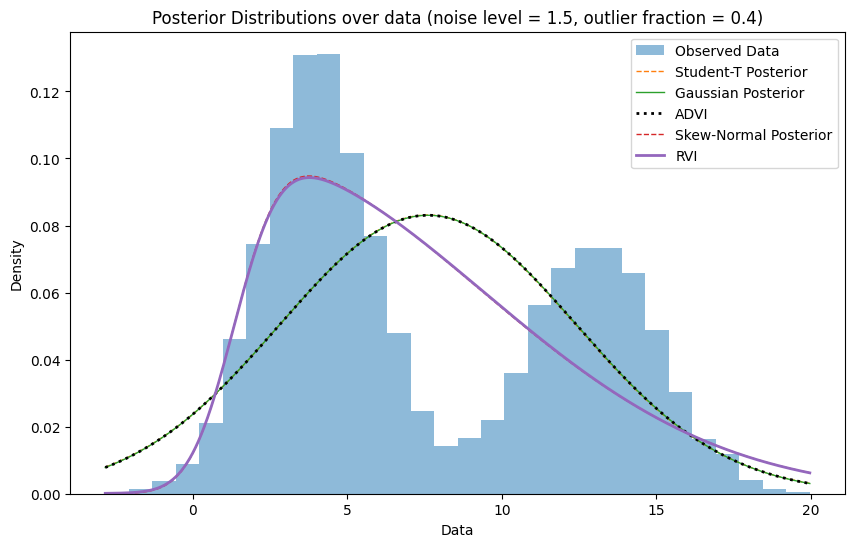

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t, norm, skewnorm

# Assuming your data is available as a numpy array
data = np.array(data)

# Define the x-range for plotting the distributions
x = np.linspace(min(data), max(data), 1000)

# Student-T distribution
studentT_pdf = t.pdf(x, df=nu_T_VI, loc=mu_T_VI, scale=sigma_T_VI)

# Normal distribution
normal_pdf = norm.pdf(x, loc=mu_norm_VI, scale=sigma_norm_VI)

# Skew-Normal distribution
skewnorm_pdf = skewnorm.pdf(x, a=alpha_VI, loc=mu_skewed_VI, scale=sigma_skewed_VI)

weighted_mixture_pdf = df_comp.loc['Student T', 'weight'] * studentT_pdf + df_comp.loc['Normal', 'weight'] * normal_pdf + df_comp.loc['Skew Normal', 'weight'] * skewnorm_pdf

# Plotting the data and distributions
plt.figure(figsize=(10, 6))

# Plot observed data histogram
plt.hist(data, bins=30, density=True, alpha=0.5, label='Observed Data')

# Plot Student-T distribution
plt.plot(x, studentT_pdf, label='Student-T Posterior', linewidth=1, linestyle = '--')

# Plot Normal distribution
plt.plot(x, normal_pdf, label='Gaussian Posterior', linewidth=1, linestyle = '-')
plt.plot(x, normal_pdf, label='ADVI', color='black', linewidth=2, linestyle = ':')

# Plot Skew-Normal distribution
plt.plot(x, skewnorm_pdf, label='Skew-Normal Posterior', linewidth=1, linestyle = '--')


plt.plot(x, weighted_mixture_pdf, label='RVI', linewidth=2, linestyle = '-')

# Add legends and titles
plt.legend()
plt.title(f'Posterior Distributions over data (noise level = {noise_level}, outlier fraction = {outlier_frac})')
plt.xlabel('Data')
plt.ylabel('Density')

# Show the plot
plt.show()


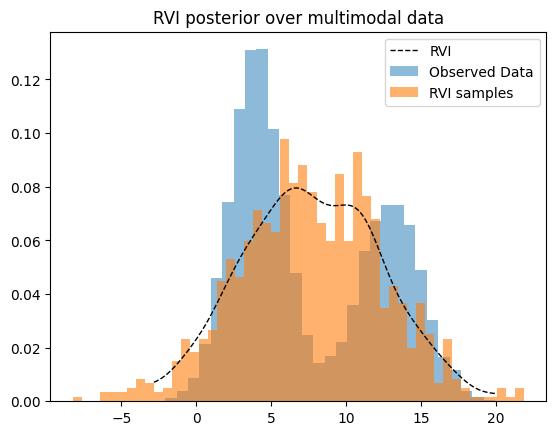

In [ ]:
import numpy as np
from scipy.stats import t, norm, skewnorm
from scipy.stats import gaussian_kde

# Convert data to numpy array
data = np.array(data)

# Define x-range for plotting
x = np.linspace(min(data), max(data), 1000)

# Student-T distribution
studentT_samples = t.rvs(df=nu_T_VI, loc=mu_T_VI, scale=sigma_T_VI, size=len(x))

# Normal distribution
normal_samples = norm.rvs(loc=mu_norm_VI, scale=sigma_norm_VI, size=len(x))

# Skew-Normal distribution
skewnorm_samples = skewnorm.rvs(a=alpha_VI, loc=mu_skewed_VI, scale=sigma_skewed_VI, size=len(x))

# Define selection probabilities for each component (assumed given in df_comp)
weights = df_comp['weight'].values

# Sample from the mixture model
chosen_indices = np.random.choice(len(weights), size=len(x), p=weights)
mixture_samples = np.where(
    chosen_indices == 0, studentT_samples,
    np.where(chosen_indices == 1, normal_samples, skewnorm_samples)
)

kde = gaussian_kde(mixture_samples)
density_vals = kde(x)


# Plot mixture samples (if needed)
import matplotlib.pyplot as plt
plt.plot(x, density_vals, color='black', linewidth=1, linestyle = '--', label="RVI")
plt.hist(data, bins=30, density=True, alpha=0.5, label='Observed Data')
plt.hist(mixture_samples, bins=50, density=True, alpha=0.6, label="RVI samples")
plt.title(f'RVI posterior over multimodal data')
plt.legend()
plt.show()

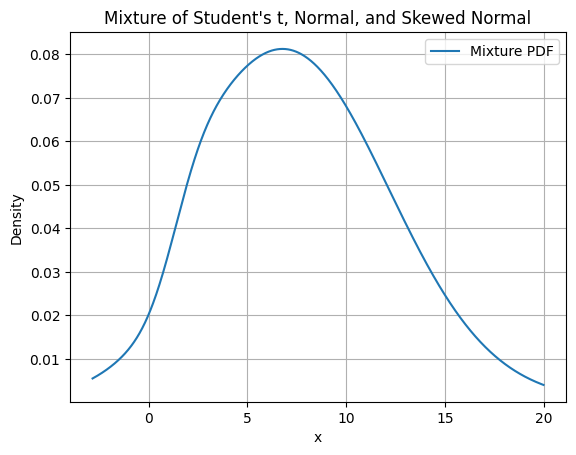

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t, skewnorm

# Parameters for each distribution
params_t = {'df': nu_T_VI, 'loc': mu_T_VI, 'scale': sigma_T_VI}        # Student's t
params_norm = {'loc': mu_norm_VI, 'scale': sigma_norm_VI}              # Normal
params_skewnorm = {'a': alpha_VI, 'loc': mu_skewed_VI, 'scale': sigma_skewed_VI} # Skewed Normal

weights = [0.3, 0.4, 0.3]  # t, normal, skewnorm

# Mixture PDF
# def mixture_pdf(x):
#     return (df_comp.loc['Student T', 'weight'] * t.pdf(x, **params_t) +
#              df_comp.loc['Normal', 'weight'] * norm.pdf(x, **params_norm) +
#             df_comp.loc['Skew Normal', 'weight'] * skewnorm.pdf(x, **params_skewnorm))

def mixture_pdf(x):
    return (weights[0]* t.pdf(x, **params_t) +
             weights[1]* norm.pdf(x, **params_norm) +
            weights[2]* skewnorm.pdf(x, **params_skewnorm))

x = np.linspace(min(data), max(data), 1000)
y = mixture_pdf(x)

plt.plot(x, y, label='Mixture PDF')
plt.title("Mixture of Student's t, Normal, and Skewed Normal")
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()
